<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Direct-rbf-basis" data-toc-modified-id="Direct-rbf-basis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Direct rbf basis</a></span></li><li><span><a href="#More-precision-with-try_direct_rbf_basis" data-toc-modified-id="More-precision-with-try_direct_rbf_basis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>More precision with try_direct_rbf_basis</a></span></li></ul></div>

## Direct rbf basis
Use finish dimension of $\Phi$ to proximate the kernel, via
$$
K(x_i, x_j) \approx \Phi^T(x_i) \Phi(x_j)
$$
We use the svd of $\Phi$ to evaluate the $K(Y,X)K^{-1}(X,X)$ like the normal (unkerneled)  ridge regression.

In [28]:
import numpy as np

class RBF:
    '''
    kij = exp(-(d(xi, xj))^2/(2 l^2))
    '''
    def __init__(self, length_scale = 1.0, sigma = 1.):
        self.length_scale = length_scale
        self.sigma = sigma
        
    def __call__(self, X, Y=None):
        '''
        (X.shape[0], X.shape[1])
        '''
        if Y is None:
            Y = X
            
        distance2 = np.square(X[:,np.newaxis,:] - Y[np.newaxis,:,:]).sum(axis=2)
        distance2 /= 2*self.length_scale**2
        K = np.exp(-distance2)
        K *= self.sigma
        return K
        
def Zero(X):
    return np.zeros(X.shape[0])
        
class GaussianProcessRegressor:
    
    def __init__(self, m = None, kernel=None, alpha=1E-10, try_direct_rbf_basis=False):
            
        self.kernel = kernel
            
        self.m = m
        
        self.alpha = alpha
        
        self.try_direct_rbf_basis = try_direct_rbf_basis
        
    def fit(self, X, y):
        '''
        X should be 2D matrix
        If you have only 1 feature use shape of (N,1)
        '''
        
        self.kernel_ = self.kernel
        if self.kernel_ is None:
            self.kernel_ = RBF(length_scale = 1.0, sigma = 1.0)
            
        
        self.m_ = self.m
        if self.m_ is None:
            self.m_ = Zero
            
        X = np.array(X, dtype=np.float_)
        y = np.array(y, dtype=np.float_)
        
        y = y - self.m_(X)
        KXX = self.kernel_(X, X)
        
            
        if self.alpha != 0:
            KXX += self.alpha * np.eye(X.shape[0])

        try:
            invKXX = np.linalg.inv(KXX)
            weights = invKXX.dot(y)
            self.invKXX = invKXX
            self.coef_ = weights
        except:
            pass
            
        
        self.X = X
        self.y = y
        self.y_m = y
        self.KXX = KXX
        
        
    def predict(self, X, return_std=False):
        '''
        X should be 2D matrix
        If you have only 1 feature use shape of (N,1)
        '''
        X = np.array(X, dtype=np.float_)
        
        Y = X
        X = self.X
        KYX = self.kernel_(Y, X)
        
        ok = False
        if self.try_direct_rbf_basis and type(self.kernel_) is RBF and self.X.shape[1] == 1:
            Ng = 1000
            
            Xmin = min(Y.min(), self.X.min()) - self.kernel_.length_scale*5
            Xmax = max(Y.max(), self.X.max()) + self.kernel_.length_scale*5
            
            ok = ((Xmax - Xmin)/Ng < 0.1*self.kernel_.length_scale)
            if ok:
                length_scale = self.kernel_.length_scale
                sigma = self.kernel_.sigma
                dx = (Xmax -  Xmin)/Ng

                X_ = np.linspace(Xmin, Xmax, Ng)

                h = np.sqrt(np.abs(sigma)) * 1/np.sqrt(np.sqrt(np.pi/2) * length_scale) *\
                        np.exp(-(X - X_[np.newaxis,:])**2/(length_scale**2)) * np.sqrt(dx)

                hhat = np.sqrt(np.abs(sigma)) * 1/np.sqrt(np.sqrt(np.pi/2) * length_scale) *\
                        np.exp(-(Y - X_[np.newaxis,:])**2/(length_scale**2)) * np.sqrt(dx)
                

                U,S,VT = np.linalg.svd(h, full_matrices=False)

                invD = S/(S*S+self.alpha)
                weights = VT.T.dot(   (invD * U).T.dot(self.y_m)  )
                f = hhat.dot(weights) + self.m_(Y)

                
                if not return_std:
                    return f
                
                U,S,VT = np.linalg.svd(h, full_matrices=True)
                VThT = VT.dot(hhat.T)

                INg = np.ones(h.shape[1])
                dg = self.alpha/(S*S+self.alpha)
                INg[:len(dg)] = dg
                
                                
                cov = VThT.T.dot(  INg[:,np.newaxis] * VThT )

                cov = cov + self.alpha * np.eye(Y.shape[0])

                return f, np.sqrt(np.maximum(0, np.diagonal(cov)))
            
        if not ok:
            f = KYX.dot(self.coef_) + self.m_(Y)

            if not return_std:
                return f

            invKXX =  self.invKXX        
            KYY = self.kernel_(Y, Y) + self.alpha * np.eye(Y.shape[0])
            KXY =  KYX.T
            KYY_post = KYY - KYX.dot( invKXX.dot(KXY) )
            return f, np.sqrt(np.maximum(0, np.diagonal(KYY_post)))
        
        

## More precision with try_direct_rbf_basis

                        dx 0.0000010001
                     truth 0.4050878004
try_direct_rbf_basis= True 0.4050875088
try_direct_rbf_basis=False 0.4049654965


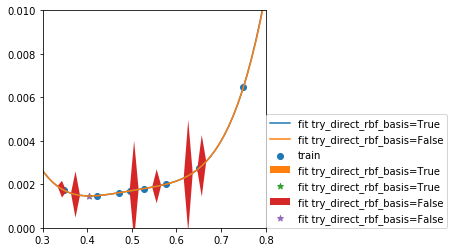

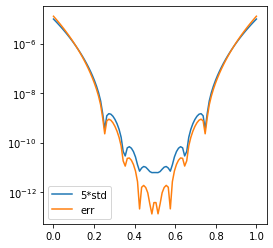

In [167]:
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
X_train = 0.5 + np.square(np.abs(np.linspace(0,1,10).reshape(-1,1) - 0.5))*np.sign(np.linspace(0,1,10).reshape(-1,1) - 0.5)

y_train = ((X_train[:,0]-0.5)**4) + 0.00342*X_train[:,0]
X_plt = np.linspace(0,1, 100)
y_plt_ = ((X_plt-0.5)**4) + 0.00342*X_plt

X_search = np.linspace(0.40,0.41, 10000)

gpr1=GaussianProcessRegressor(kernel=RBF(1,1), alpha=(1E-12)**2, try_direct_rbf_basis=True)
gpr1.fit(X_train, y_train)
y_plt1, std1 = gpr1.predict(X_plt.reshape(-1,1), return_std=True)

y_search = gpr1.predict(X_search.reshape(-1,1))
xmin1 = X_search[np.argmin(y_search)]
ymax1 = np.min(y_search)

# continuing reducing alpha will introduce numerical unstability
gpr2=GaussianProcessRegressor(kernel=RBF(1,1), alpha=3E-6**2, try_direct_rbf_basis=False)
gpr2.fit(X_train, y_train)
y_plt2, std2 = gpr2.predict(X_plt.reshape(-1,1), return_std=True)

y_search = gpr2.predict(X_search.reshape(-1,1))
xmin2 = X_search[np.argmin(y_search)]
ymax2 = np.min(y_search)

print("                        dx", "%.10f"%(X_search[1]-X_search[0]))
print("                     truth", "%.10f"%(0.5 - np.power(0.00342/4,1/3)))
print("try_direct_rbf_basis= True", "%.10f"%xmin1)
print("try_direct_rbf_basis=False", "%.10f"%xmin2)

plt.figure(figsize=(4,4))
plt.scatter(X_train, y_train, label="train")

plt.plot(X_plt, y_plt1, label="fit try_direct_rbf_basis=True")
plt.fill_between(X_plt, y_plt1-std1, y_plt1+std1, label="fit try_direct_rbf_basis=True")
plt.scatter([xmin1], [ymax1], marker="*", label="fit try_direct_rbf_basis=True")

plt.plot(X_plt, y_plt2, label="fit try_direct_rbf_basis=False")
plt.fill_between(X_plt, y_plt2-std2, y_plt2+std2, label="fit try_direct_rbf_basis=False")
plt.scatter([xmin2], [ymax2], marker="*",  label="fit try_direct_rbf_basis=False")
plt.legend(loc=(1,0))
plt.xlim((0.3,0.8))
plt.ylim((0.00,0.01))
plt.show()


plt.figure(figsize=(4,4))
plt.plot(X_plt, 5*std1, label="5*std")
plt.plot(X_plt, np.abs(y_plt_ - y_plt1), label="err")
plt.yscale("log")
plt.legend()
plt.show()